In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from matplotlib.patches import Polygon
import glob
import os as os

In [ ]:
basepath = r"path"

# colors
lakecolor = '#ca3e3dff' 
marinecolor = '#46556aff'
lightmarine = '#707c92ff'
background = '#f8f6f4ff'#f7f5efff, # f3f1efff
shading = '#e7e5e3ff'
darkred = '#9c2626ff'
olive = '#677834ff'
lightolive = '#9da737ff'
darkolive = '#364621ff'

def read_LT_margins(path):
    LT = pd.read_csv(path, 
                        skiprows=2,
                        names = ["year", "month", "day", "serial_date", "pos_flowline", "pos_rel", "change","change_rate", "terminus_width", "path_length", "node_distance", "box_width", "box_area"]
                        )

    LT['date'] = pd.to_datetime(LT['year'].astype(str) + '-' + LT['month'].astype(str) + '-' + LT['day'].astype(str))
    LT.index = LT['date']
    LT.sort_index(inplace = True)
    LT['pos_rel_inv'] = (((LT['pos_rel'] - LT['pos_rel'].iloc[2])*(-1))/1000)
    return LT

In [ ]:
# reading LT margins
LT = read_LT_margins(basepath + r"\3.1_glacier_margins_and_flowline\LT_margins.csv")
calving = LT[LT['change'] <= -50].index

# reading runoff data
runoff = pd.read_csv(basepath + r"\3.8_racmo_oras5\runoff_whole_catchment.csv", usecols=["time", 'runoffcorr'], index_col='time', parse_dates=True, )

#reading lake ice data (see file with lake ice classfication in 3.7)
breakup = [
    "2014-05-24", "2015-06-21", "2016-05-13", "2017-05-25", "2018-05-29",
    "2019-05-09", "2020-05-21", "2021-05-02", "2022-05-18", "2023-05-16", "2024-05-15"
]

freezeup = [
    "2024-10-17", "2023-10-18", "2022-10-08", "2021-10-27", "2020-10-30",
    "2019-10-14", "2018-10-11", "2017-10-14", "2016-10-21", "2015-11-03", "2014-10-24"
]


freezeup = freezeup[::-1]

# reading and processing LT velocities
LT_raw = pd.read_csv(basepath + r"\3.3_ice_surface_velocities\LT_ticoi_itslive_dataf.csv")
LT_inv = pd.read_csv(basepath + r"\3.3_ice_surface_velocities\LT_ticoi_itslive_dataf_lp.csv")

LT_raw = LT_raw[LT_raw['label'] == 'K'].copy()
LT_inv = LT_inv[LT_inv['label'] == 'K'].copy()

LT_raw['date_cori'] = pd.to_datetime(LT_raw['date_cori'])
LT_inv['date_cori'] = pd.to_datetime(LT_inv['date_cori'])
LT_raw['offset_bar'] = pd.to_timedelta(LT_raw['offset_bar'])
LT_inv['offset_bar'] = pd.to_timedelta(LT_inv['offset_bar'])

In [11]:
# Define the runoff threshold
threshold = 2

# Create a DataFrame to store the results
runoff_periods = []

# Group the data by year
for year, group in runoff.groupby(runoff.index.year):
    # Filter the group for runoff values above the threshold
    above_threshold = group[group['runoffcorr'] >= threshold]
    
    if not above_threshold.empty:
        # Get the first and last day of the runoff period
        start_date = above_threshold.index.min()
        end_date = above_threshold.index.max()
        
        # Append the results to the list
        runoff_periods.append({'year': year, 'start_date': start_date, 'end_date': end_date})

# Convert the results to a DataFrame
runoff_periods_df = pd.DataFrame(runoff_periods)


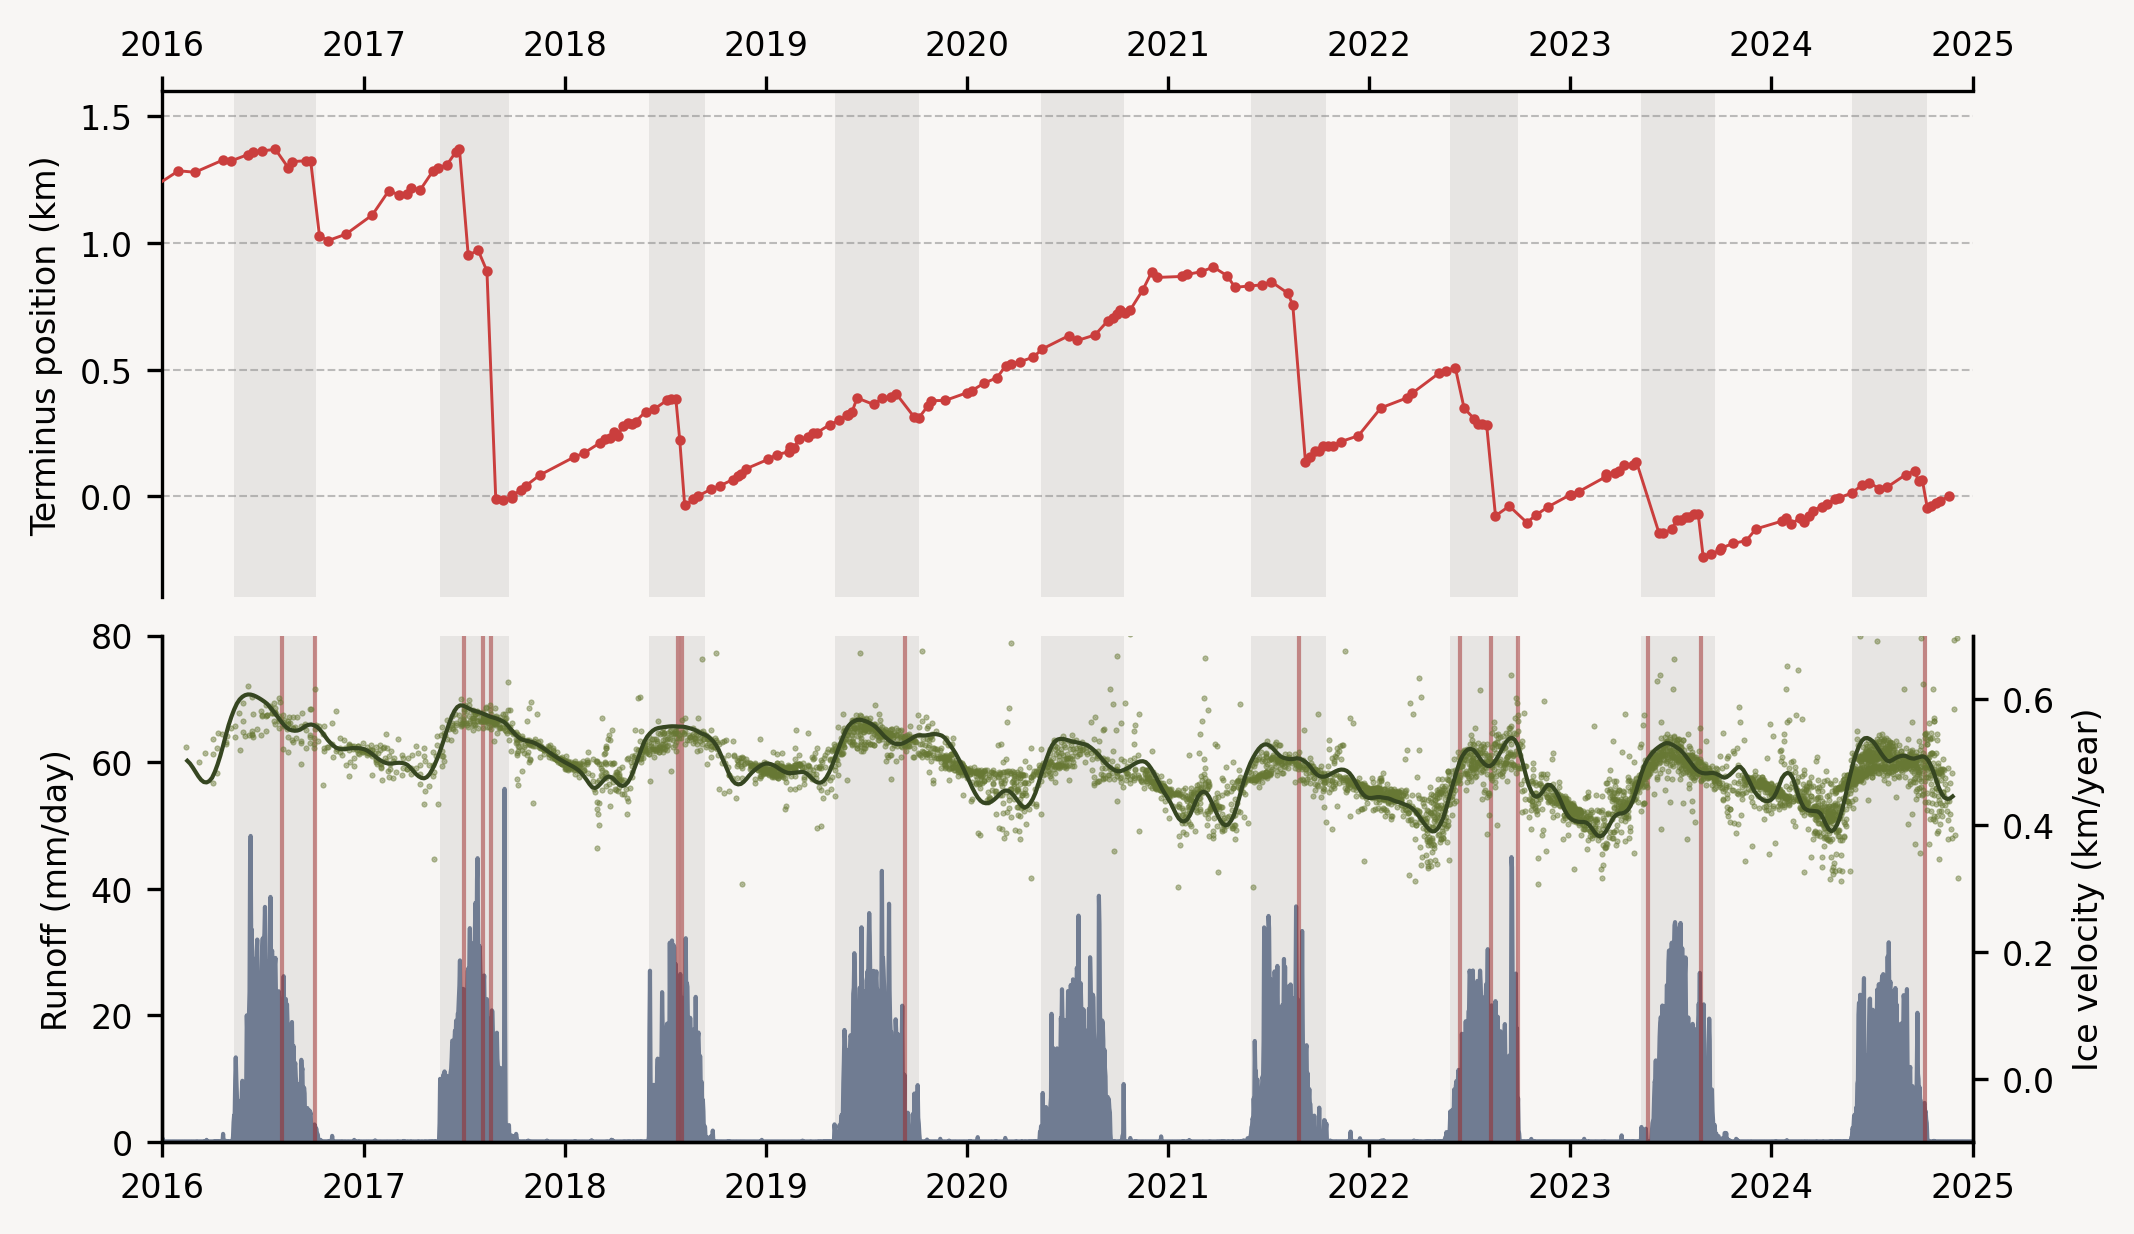

In [ ]:
LT.index = pd.to_datetime(LT.index)
runoff.index = pd.to_datetime(runoff.index)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 4), dpi=300 , facecolor=background, layout="constrained")

# Background color
ax.set_facecolor(background)
ax2.set_facecolor(background)

# Plot data
ax.plot(LT.index, LT.pos_rel/1000, marker = 'o', markersize= 1.5, linewidth=0.7, color = lakecolor , label = 'LT Terminus position', zorder = 5)
ax2.fill_between(runoff.index, 0, runoff.runoffcorr, color= lightmarine, zorder = 1, label = 'Runoff (RACMO2.3p2)')

ax3 = ax2.twinx()
#ax3.scatter(velo_LT.index, velo_LT.v, marker='o', s=0.4, color=olive, alpha = 0.6)
#ax3.plot(velo_LT.index, velo_LT.v.rolling('90D', center=True).median(), linewidth=1, color=darkolive, zorder=6, label='Velocity (90-d running mean)')

ax3.scatter(LT_raw['date_cori'], LT_raw['vv']/1000, marker='o', s=0.2, color=olive, alpha = 0.6, label='Observations with time span')
ax3.plot(LT_inv['date_cori'], LT_inv['vv']/1000, color=darkolive, linewidth=1, label='Inverted velocity')


# set axis limits
ax.set_xlim(date(2016, 1, 1), date(2025, 1, 1))
ax2.set_xlim(date(2016, 1, 1), date(2025, 1, 1))

ax.set_ylim(-0.4, 1.6)
ax2.set_ylim(0, 80)
ax3.set_ylim(-0.1, 0.7)

# adjust spines
ax.spines[[ 'bottom', 'right']].set_visible(False)
ax2.spines[[ 'top']].set_visible(False)
ax3.spines[[ 'top']].set_visible(False)
ax.spines.left.set_bounds(-0.4, 1.6)

# and ticks
ax.tick_params(right = False,
                labelright= False,
                labelbottom = False,
                bottom = False,
                top =True,
                labeltop= True,
                labelsize = 8,
               ) # direction='in',length=10,color='black',width=0.5,

# and ticks
ax2.tick_params(right = False,
                labelright= False,
                labelbottom = True,
                bottom = True,
                top =False,
                labeltop= False,
                labelsize = 8,
               ) # direction='in',length=10,color='black',width=0.5,

ax3.tick_params(right = True,
                labelright= True,
                labelbottom = True,
                bottom = True,
                top =False,
                labeltop= False,
                labelsize = 8,
                labelleft = False,
                left = False,
               ) # direction='in',length=10,color='black',width=0.5,
                

   
# mark calving events
for calv in calving:
    previous_index = LT.index[LT.index.get_loc(calv) - 1]
    midpoint = previous_index + (calv - previous_index) / 2
    ax2.axvline(midpoint, color=darkred, linewidth=1, alpha=0.5)

    
# Plot shading for runoff periods
for _, row in runoff_periods_df.iterrows():
    ax.axvspan(row['start_date'], row['end_date'], facecolor = shading, alpha=1, edgecolor='none', zorder = 0)
    ax2.axvspan(row['start_date'], row['end_date'], facecolor = shading, alpha=1, edgecolor='none', zorder = 0)


# add text
ax.set_ylabel('Terminus position (km)', fontsize = 8)
ax2.set_ylabel('Runoff (mm/day)', fontsize = 8)
ax3.set_ylabel('Ice velocity (km/year)', fontsize = 8)

# grid
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#ax2.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

# save figure
#fig.savefig(r'path', dpi=300)